In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from mmctools.helper_functions import calc_wind, power_spectral_density, calc_spectra
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram, plot_spectrum
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# tower location & domain number to analyze
sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 
            'les200m': ['c1.d03', d03_wrf_dt], 
            'les40m': ['c1.d04', d04_wrf_dt]}

les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# 1 obs height in m, to match wrf's heights
share_height = [4, 25]

In [16]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def read_wrf_ts(eval_date, sim):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    mynn_file_path = wrf_runs_dir+col['mynn']+'/z_ts/z.'+sim_val[0]
    mynn_tower = Tower(mynn_file_path)

    mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, sim_val[1])
    mynn_ds['wspd'], mynn_ds['wdir'] = calc_wind(mynn_ds)
    
    edmf_file_path = wrf_runs_dir+col['edmf']+'/z_ts/z.'+sim_val[0]
    edmf_tower = Tower(edmf_file_path)

    edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, sim_val[1])
    edmf_ds['wspd'], edmf_ds['wdir'] = calc_wind(edmf_ds)
   
    return mynn_ds, edmf_ds

def plot_spectra(eval_date, sim): 

    mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

    obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    if sim == 'meso': 

        obs_ds = obs_ds.sel(time=eval_date)
        mynn_ds = mynn_ds.sel(datetime=eval_date)
        edmf_ds = edmf_ds.sel(datetime=eval_date)

    else: 

        time_start = np.max([mynn_ds['datetime'].min().values, edmf_ds['datetime'].min().values, 
                             obs_ds['time'].min().values]) + les_spinup
        time_end = np.min([mynn_ds['datetime'].max().values, edmf_ds['datetime'].max().values, 
                           obs_ds['time'].max().values])

    #     print(time_start, time_end)

        obs_ds = obs_ds.sel(time=slice(time_start, time_end))
        mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
        edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))

    obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

    mynn_spectra = calc_spectra(mynn_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    edmf_spectra = calc_spectra(edmf_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.rcParams.update({'font.size': 12})
    
    _, ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                      'edmf': edmf_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True, fig=fig, ax=ax)

    plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

    plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

    plt.show()

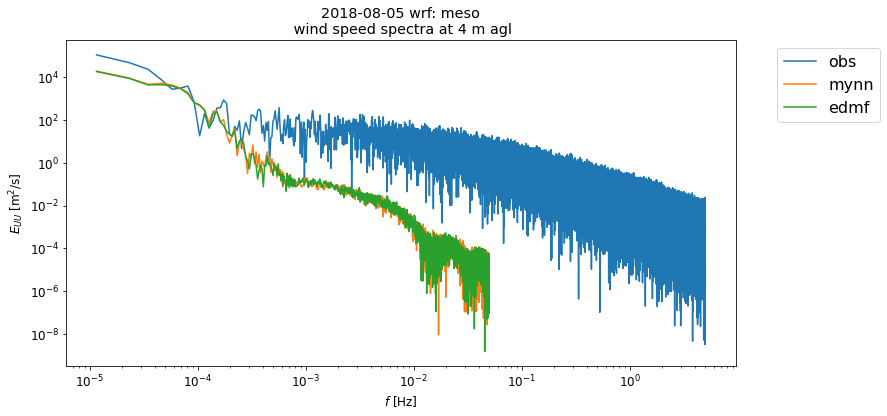

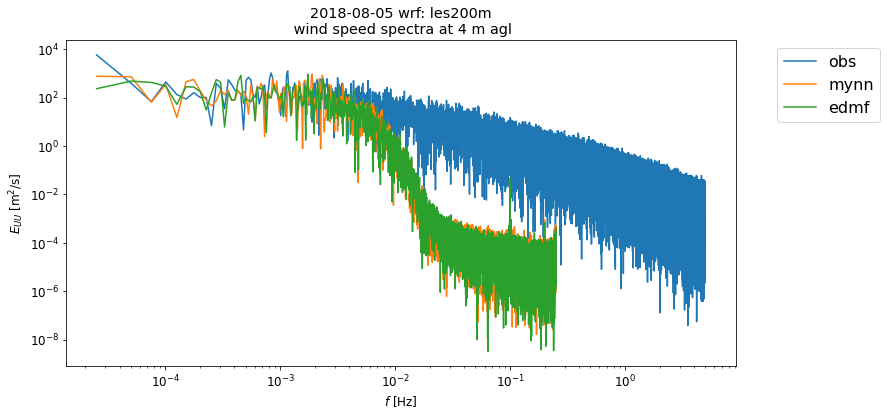

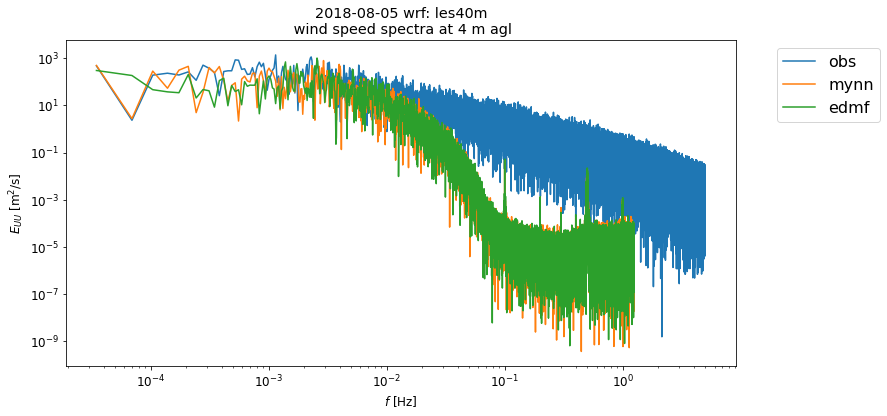

In [17]:
eval_date = '2018-08-05'

for sim in sim_dict.keys(): 
    plot_spectra(eval_date, sim)

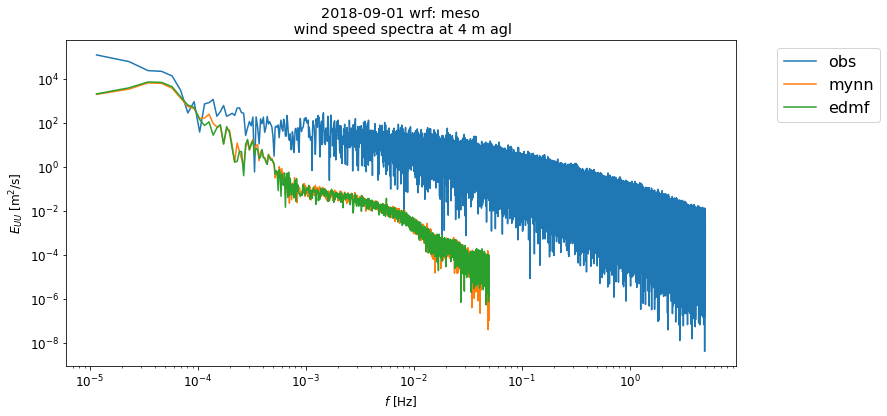

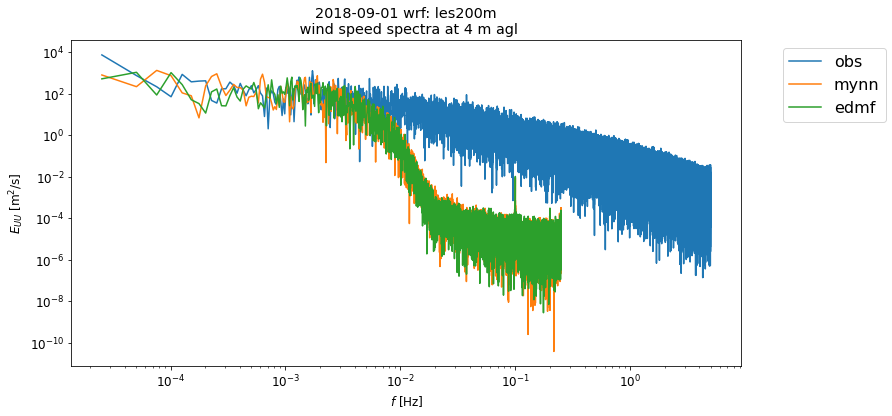

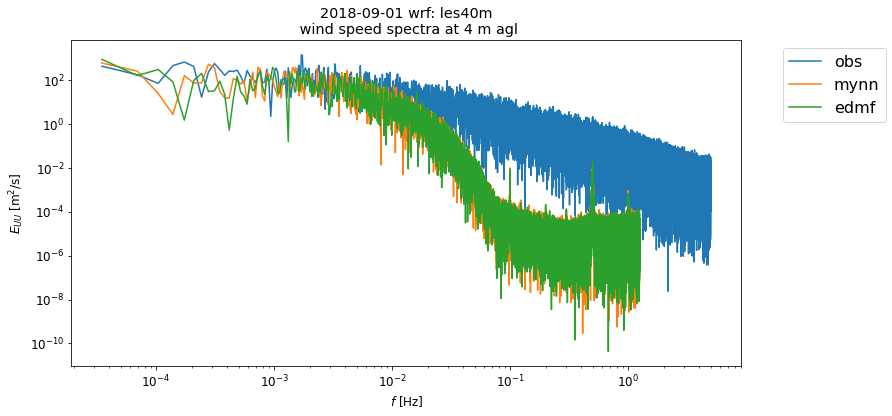

In [18]:
eval_date = '2018-09-01'

for sim in sim_dict.keys(): 
    plot_spectra(eval_date, sim)

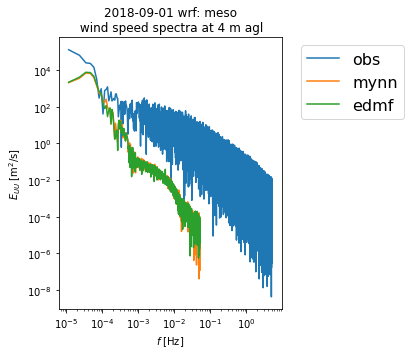

In [8]:
plot_spectra(eval_date, 'meso')

In [3]:
sim_dict.keys()

dict_keys(['meso', 'les200m', 'les40m'])

In [5]:
eval_date = '2018-09-01'
sim = 'meso'

# mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

In [6]:
obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

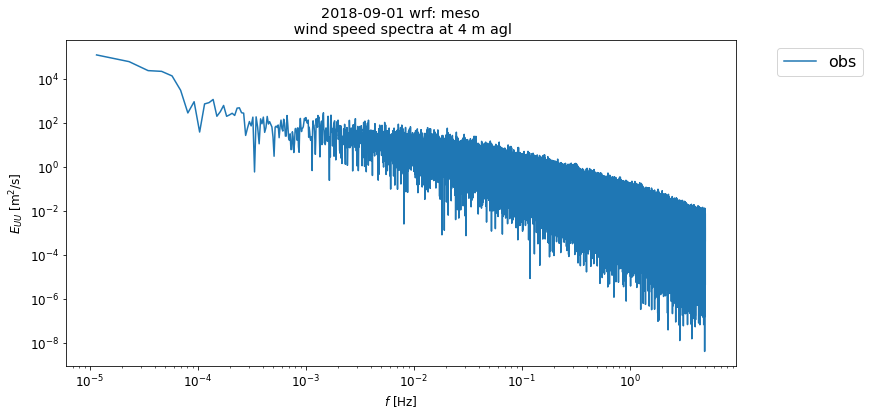

In [15]:
obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

fig, ax = plt.subplots(figsize=(12, 6))

plt.rcParams.update({'font.size': 12})

# axis_font = {'fontname':'Arial', 'size':'14'}

_, ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
#                   'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
#                   'edmf': edmf_spectra.sel(height=4).to_dataframe()
                 },
        fields='wspd',
        showlegend=True, fig=fig, ax=ax)

# plt.rcParams.update({'font.size': 2})

plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

plt.show()

In [27]:
def plot_spectra(eval_date, sim): 

    mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

    obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    if sim == 'meso': 

        obs_ds = obs_ds.sel(time=eval_date)
        mynn_ds = mynn_ds.sel(datetime=eval_date)
        edmf_ds = edmf_ds.sel(datetime=eval_date)

    else: 

        time_start = np.max([mynn_ds['datetime'].min().values, edmf_ds['datetime'].min().values, 
                             obs_ds['time'].min().values]) + les_spinup
        time_end = np.min([mynn_ds['datetime'].max().values, edmf_ds['datetime'].max().values, 
                           obs_ds['time'].max().values])

    #     print(time_start, time_end)

        obs_ds = obs_ds.sel(time=slice(time_start, time_end))
        mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
        edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))

    obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

    mynn_spectra = calc_spectra(mynn_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    edmf_spectra = calc_spectra(edmf_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                      'edmf': edmf_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True)

    plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

    plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

    plt.show()

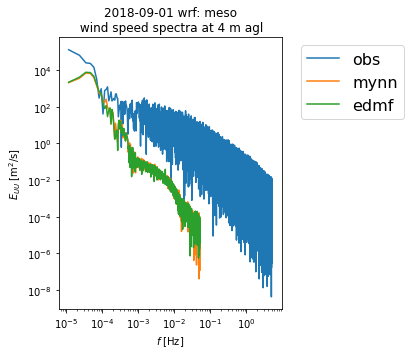

In [28]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

plt.show()

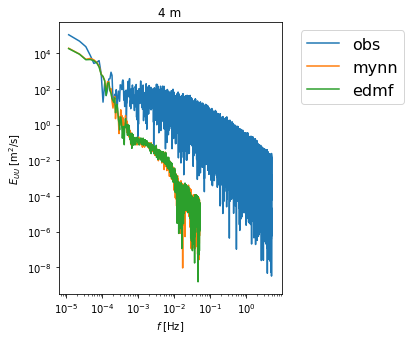

In [9]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title('4 m')

plt.show()

In [11]:
mynn_ds

<xarray.Dataset>
Dimensions:      (datetime: 8640, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 310.4 310.2 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.755e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01057 ... -0.028
    u            (datetime, height, station) float64 0.2213 0.4659 ... -0.6489
    qv           (datetime, height, station) float64 0.01209 0.01191 ... 0.01069
    v            (datetime, height, station) float64 4.882 8.049 ... 4.891 8.275
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 308.2 308.2 308.2 ... 310.2 310.3
    q2           (datetime, station) float64 0.01211 0.01211 ... 0.01089 0.01089
    u10          (datetime, station) float64 0.3213 0.3168 ... -0.5808 -0.5749
    v10          (datetime, station) float64 6.414 6.413 6.412 ... 6.498 6.494
    psfc         (datetime, station) float64 9.758e+04 9.758e+04 ... 9.757e+04
    glw          (datetime, station) float64 426.2 426.3 426.3 ... 425.9 425.9
    gsw          (datetime, station) float64 192.6 183.8 183.8 ... 194.3 194.3
    hfx          (datetime, station) float64 19.7 14.62 14.71 ... 7.478 7.213
    lh           (datetime, station) float64 82.24 79.88 79.85 ... 79.07 79.04
    tsk          (datetime, station) float64 308.5 308.4 308.4 ... 310.4 310.4
    slttop       (datetime, station) float64 307.7 307.7 307.7 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.02772 0.02772 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 40.85 40.85 40.85 ... 33.41 33.4
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    swp          (datetime, station) float64 0.00072 0.00073 0.00075 ... 0.0 0.0
    wp_sum       (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    re_qs        (datetime, station) float64 7e-05 7e-05 7e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.00496 0.00499 0.00506 ... 0.0 0.0
    tau_qs       (datetime, station) float64 0.03665 0.03746 ... 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0049 0.00497 0.00499 ... 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.5978 0.5904 ... 0.609 0.609
    sza          (datetime, station) float64 73.29 73.32 

In [30]:
time_start, time_end

(numpy.datetime64('2018-08-05T00:00:00.000000000'),
 numpy.datetime64('2018-08-05T23:59:50.000000000'))

In [31]:
obs_ds_test = obs_ds.sel(time=slice(time_start, time_end))

In [32]:
obs_ds_test

<xarray.Dataset>
Dimensions:            (time: 863901)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(863901,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [28]:
mynn_ds.sel(datetime=slice(eval_date, eval_date))

<xarray.Dataset>
Dimensions:      (datetime: 8640, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 310.4 310.2 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.755e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01057 ... -0.028
    u            (datetime, height, station) float64 0.2213 0.4659 ... -0.6489
    qv           (datetime, height, station) float64 0.01209 0.01191 ... 0.01069
    v            (datetime, height, station) float64 4.882 8.049 ... 4.891 8.275
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 308.2 308.2 308.2 ... 310.2 310.3
    q2           (datetime, station) float64 0.01211 0.01211 ... 0.01089 0.01089
    u10          (datetime, station) float64 0.3213 0.3168 ... -0.5808 -0.5749
    v10          (datetime, station) float64 6.414 6.413 6.412 ... 6.498 6.494
    psfc         (datetime, station) float64 9.758e+04 9.758e+04 ... 9.757e+04
    glw          (datetime, station) float64 426.2 426.3 426.3 ... 425.9 425.9
    gsw          (datetime, station) float64 192.6 183.8 183.8 ... 194.3 194.3
    hfx          (datetime, station) float64 19.7 14.62 14.71 ... 7.478 7.213
    lh           (datetime, station) float64 82.24 79.88 79.85 ... 79.07 79.04
    tsk          (datetime, station) float64 308.5 308.4 308.4 ... 310.4 310.4
    slttop       (datetime, station) float64 307.7 307.7 307.7 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.02772 0.02772 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 40.85 40.85 40.85 ... 33.41 33.4
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    swp          (datetime, station) float64 0.00072 0.00073 0.00075 ... 0.0 0.0
    wp_sum       (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    re_qs        (datetime, station) float64 7e-05 7e-05 7e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.00496 0.00499 0.00506 ... 0.0 0.0
    tau_qs       (datetime, station) float64 0.03665 0.03746 ... 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0049 0.00497 0.00499 ... 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.5978 0.5904 ... 0.609 0.609
    sza          (datetime, station) float64 73.29 73.32 

In [25]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

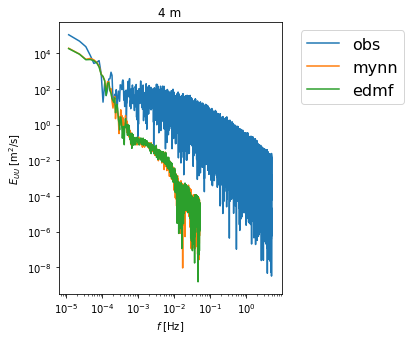

In [26]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title('4 m')

plt.show()

In [23]:
eval_date.replace('-', '')

'20180805'

In [5]:
data_dir_df['2018-08-05']

mynn              l1_0805m
edmf              l2_0805e
mynn_1arcs        l5_0805m
wrf_start     8/4/18 12:00
Name: 2018-08-05, dtype: object

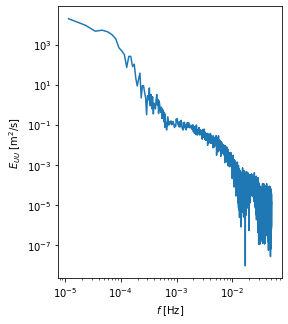

In [12]:
wrf_spectra = calc_spectra(wrf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
#                       average_dim='station',
                      level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

ax = plot_spectrum(
        datasets={'test':wrf_spectra.sel(height=4).to_dataframe(), \
                  },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
    )

In [7]:
obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.20180805.000000.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

In [8]:
obs_ds

<xarray.Dataset>
Dimensions:            (time: 864000)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(864000,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

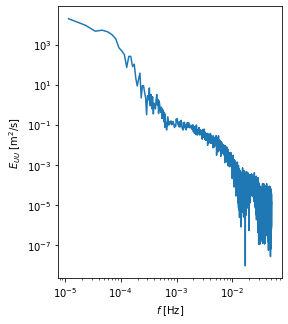

In [16]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
#                       average_dim='station',
#                       level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

# ax = plot_spectrum(
#         datasets={'test':wrf_spectra.sel(height=4).to_dataframe(), \
#                   },
#         #height=80,
#         #times=spectraTimes,
#         fields='wspd',
# #         freqlimits=(1e-3,1),
# #         fieldlimits={'wspd':(1e-3,1e2)},
#         showlegend=False,
#     )

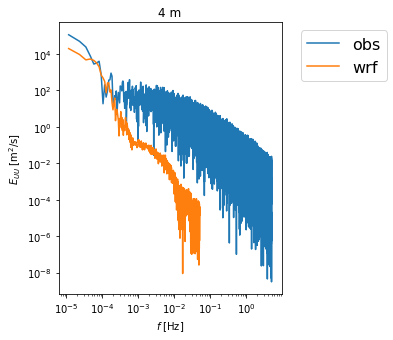

In [20]:
ax = plot_spectrum(
        datasets={'obs':obs_spectra.to_dataframe(), \
                  'wrf':wrf_spectra.sel(height=4).to_dataframe()},
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=True,
    )

plt.title('4 m')

plt.show()

In [10]:
obs_spectra

<xarray.Dataset>
Dimensions:    (frequency: 432001)
Coordinates:
  * frequency  (frequency) float64 0.0 1.157e-05 2.315e-05 ... 5.0 5.0 5.0
Data variables:
    wspd       (frequency) float32 1.026e+04 1.129e+05 ... 0.0004931 2.001e-05

In [13]:
wrf_spectra

<xarray.Dataset>
Dimensions:    (frequency: 4321, height: 2)
Coordinates:
  * height     (height) int64 4 25
  * frequency  (frequency) float64 0.0 1.157e-05 2.315e-05 ... 0.04999 0.05
Data variables:
    wspd       (height, frequency) float64 4.524e+03 1.973e+04 ... 1.597e-06

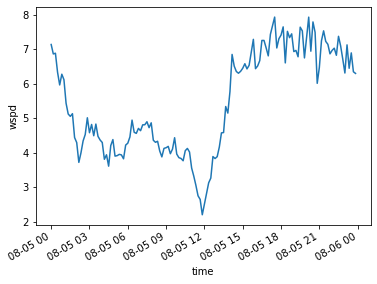

In [52]:
obs_ds['wspd'].resample(time='10min').mean().plot()

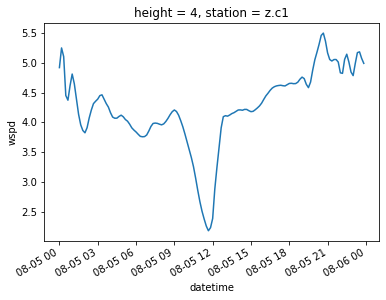

In [51]:
wrf_ds['wspd'].sel(height=4, datetime='2018-08-05').resample(datetime='10min').mean().plot()

In [32]:
obs_ds

<xarray.Dataset>
Dimensions:            (time: 864000)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(864000,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [26]:
wrf_ds

<xarray.Dataset>
Dimensions:      (datetime: 12960, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-04T12:00:10 ... 2018-08-06
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 299.7 299.8 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.788e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01089 ... -0.02726
    u            (datetime, height, station) float64 -0.8431 -0.9107 ... -0.6443
    qv           (datetime, height, station) float64 0.0101 0.01004 ... 0.01069
    v            (datetime, height, station) float64 5.54 6.123 ... 4.888 8.271
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 298.0 297.9 297.9 ... 310.3 310.2
    q2           (datetime, station) float64 0.01009 0.0101 ... 0.01089 0.01089
    u10          (datetime, station) float64 -0.909 -0.9003 ... -0.5749 -0.5695
    v10          (datetime, station) float64 6.022 5.879 5.69 ... 6.494 6.49
    psfc         (datetime, station) float64 9.791e+04 9.791e+04 ... 9.757e+04
    glw          (datetime, station) float64 376.0 376.0 376.0 ... 425.9 425.9
    gsw          (datetime, station) float64 21.27 21.27 21.27 ... 194.3 194.3
    hfx          (datetime, station) float64 -28.8 -33.22 -32.78 ... 7.213 7.407
    lh           (datetime, station) float64 16.39 16.18 16.12 ... 79.04 79.04
    tsk          (datetime, station) float64 297.5 297.3 297.3 ... 310.4 310.4
    slttop       (datetime, station) float64 301.3 301.3 301.3 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.0 0.0 0.0 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00028 0.00122 0.00158 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 37.1 37.1 37.1 ... 33.41 33.4 33.4
    lwp          (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 0.0 0.0 0.0 ... 4e-05 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.1403 0.4654 0.5659 ... 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 0.0 0.0 0.0 ... 9e-05 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.09879 0.429 ... 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.3451 0.3451 ... 0.609 0.609
    sza          (datetime, station) float64 86.8 86.

In [43]:
spectra

<xarray.Dataset>
Dimensions:    (frequency: 6481, height: 2, station: 1)
Coordinates:
  * height     (height) int64 4 25
  * frequency  (frequency) float64 0.0 7.716e-06 1.543e-05 ... 0.04999 0.05
  * station    (station) <U4 'z.c1'
Data variables:
    wspd       (height, station, frequency) float64 4.612e+03 ... 3.265e-05

In [2]:
c1_file_path = wrf_runs_dir+'l1_0805m/z_ts/z.c1.d04'
# c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
wrf_tower = Tower(c1_file_path)

# # simulation start time
wrf_start = '8/4/18 12:00'

def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, d04_wrf_dt)

wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)

In [3]:
wrf_ds

<xarray.Dataset>
Dimensions:      (datetime: 81000, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05T15:00:00.400000 ... 201...
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    w            (datetime, height, station) float64 -0.01046 ... -0.06639
    v            (datetime, height, station) float64 2.807 6.627 ... 3.663 8.823
    u            (datetime, height, station) float64 0.6833 2.253 ... -0.4742
    theta        (datetime, height, station) float64 306.2 304.9 ... 312.5 312.3
    pr           (datetime, height, station) float64 9.798e+04 ... 9.728e+04
    qv           (datetime, height, station) float64 0.01482 0.01449 ... 0.01061
    i            (station) int64 115
    j            (station) int64 270
    lat          (station) float64 36.61
    lon          (station) float64 -97.49
    zsurface     (station) float64 310.6
    t2           (datetime, station) float64 304.5 304.4 304.4 ... 310.3 310.3
    q2           (datetime, station) float64 0.01487 0.01487 ... 0.01084 0.01084
    u10          (datetime, station) float64 1.039 1.052 ... -0.4232 -0.4171
    v10          (datetime, station) float64 4.065 4.061 4.06 ... 5.461 5.46
    psfc         (datetime, station) float64 9.8e+04 9.8e+04 ... 9.752e+04
    glw          (datetime, station) float64 402.0 402.0 402.0 ... 425.6 425.6
    gsw          (datetime, station) float64 491.2 491.2 491.2 ... 187.9 187.9
    hfx          (datetime, station) float64 218.8 200.0 201.1 ... 18.66 18.68
    lh           (datetime, station) float64 108.9 103.7 104.3 ... 68.21 68.18
    tsk          (datetime, station) float64 310.1 309.5 309.3 ... 310.7 310.7
    slttop       (datetime, station) float64 300.8 300.8 300.8 ... 310.4 310.4
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.03828 0.03828 ... 0.03828 0.03828
    clw          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 36.01 36.01 36.01 ... 33.64 33.65
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 3e-05 3e-05 3e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 1e-05 1e-05 1e-05 ... 8e-05 8e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.7149 0.7149 ... 0.6078 0.6078
    sza          (datetime, station) float64 

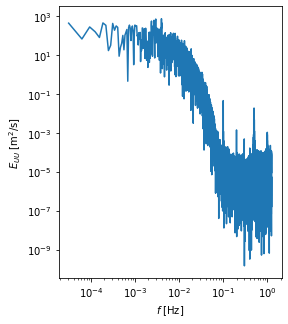

In [4]:
spectra = calc_spectra(wrf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      average_dim='station',
                      level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

ax = plot_spectrum(
        datasets={'test':spectra.sel(height=4).to_dataframe(), \
                  },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
    )

In [3]:
data_dir_df

,2018-08-05,2018-09-01
mynn,l1_0805m,l3_0901m
edmf,l2_0805e,l4_0901e
mynn_1arcs,l5_0805m,NaN
wrf_start,8/4/18 12:00,8/31/18 12:00


In [5]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def plot_flux(eval_date, row, model):

    date_col = data_dir_df[eval_date]

#     wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
#     c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
    wrf_tower = Tower(c1_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

    wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))

    for wrf_var, var in co2flx25m_dict.items(): 
        
#         print(wrf_ds['datetime'])
#         print(co2flx25m_ds['time'])

        plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var], label='wrf')
        plt.plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

        plt.title(var[0]+': '+row+' '+model+' vs '+co2flx25m_ds.platform_id+': '+eval_date)
        plt.ylabel(var[1])
        plt.axhline(color='grey', linestyle='--')
        plt.tick_params(labelrotation=90)
        plt.legend()

        plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+wrf_var+'.pdf')

        plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf')
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

        ax_i.set_title(var[1][0]+': '+row+' '+model+' vs '
                       +co2flx4m_ds.platform_id+': '+eval_date)
        ax_i.set_ylabel(var[1][1])
        ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)
        ax_i.legend()

    p2_txt = '_'.join([str(elem) for elem in list(co2flx4m_dict.keys())])    

    plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+p2_txt+'.pdf')

    plt.show()
    
    return wrf_ds

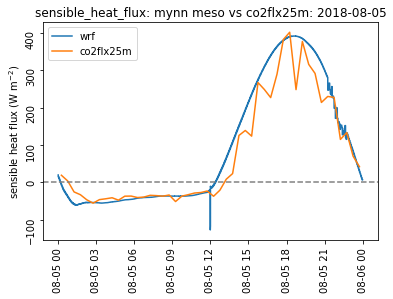

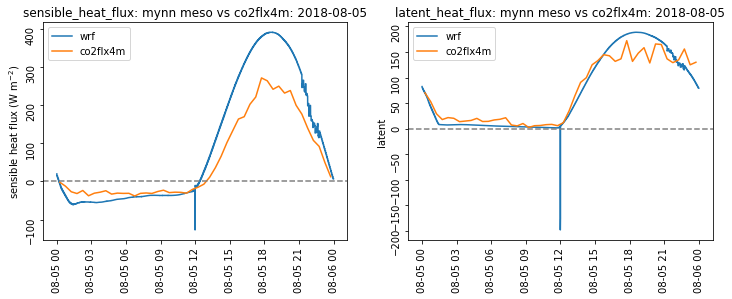

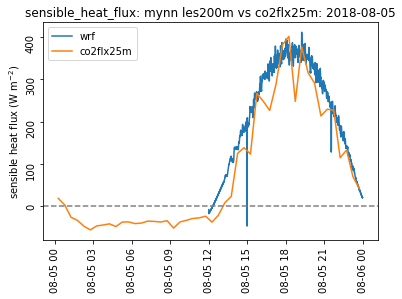

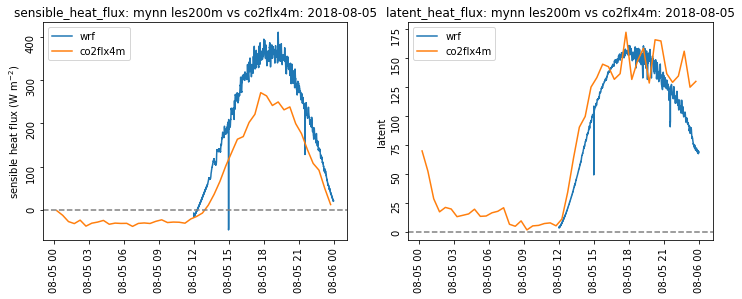

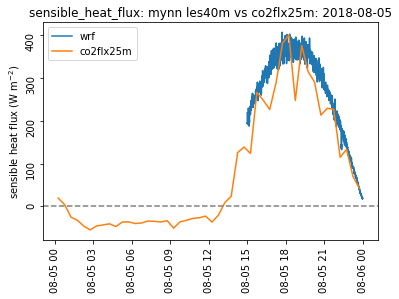

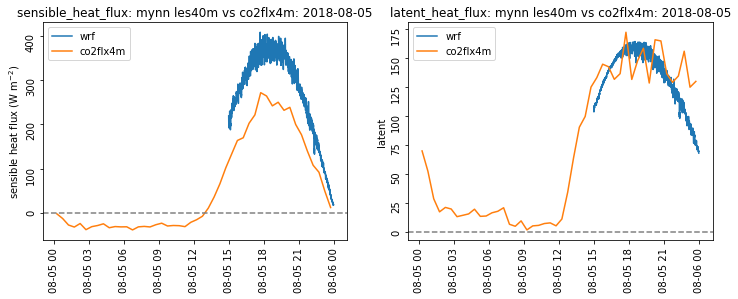

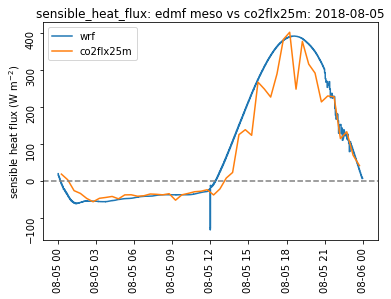

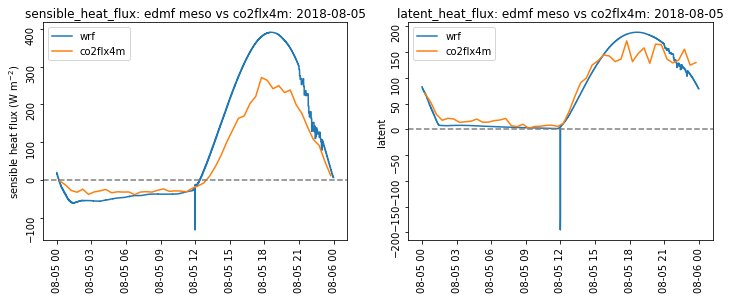

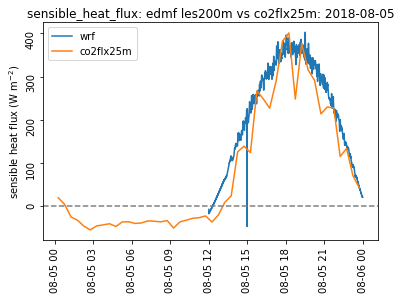

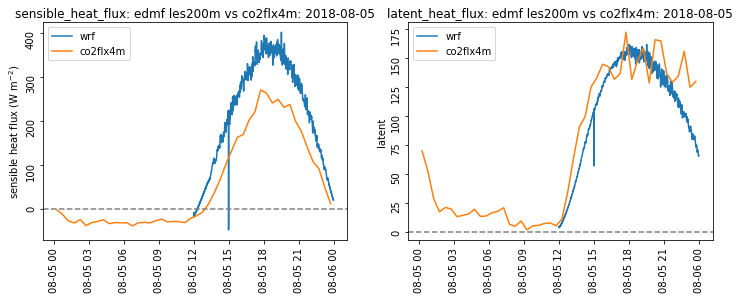

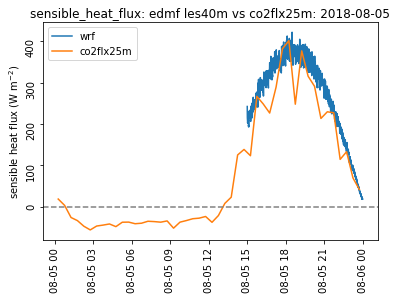

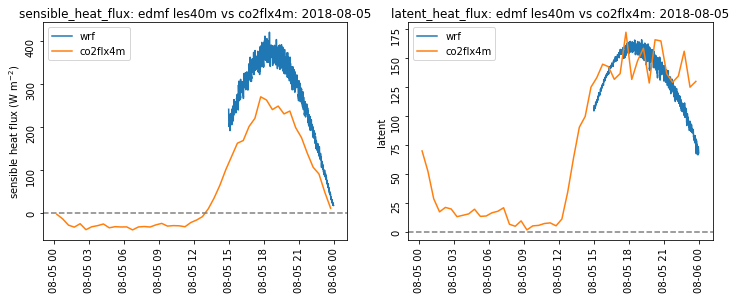

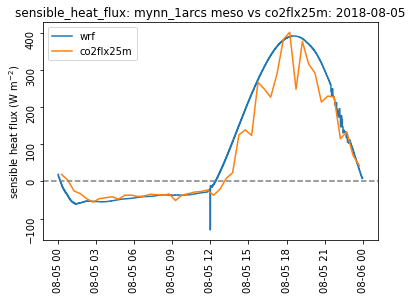

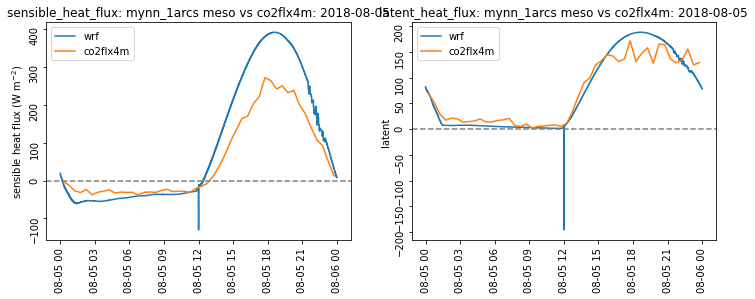

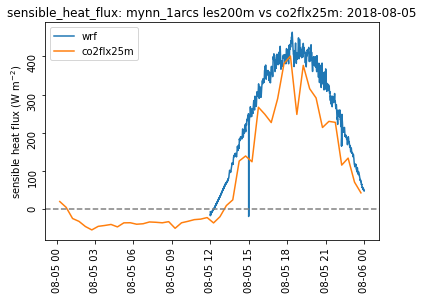

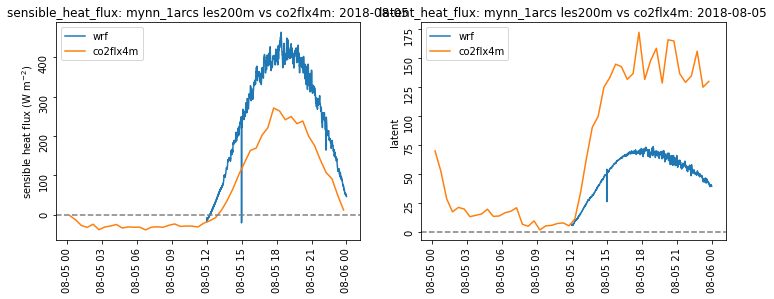

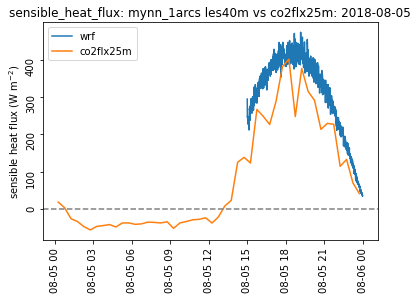

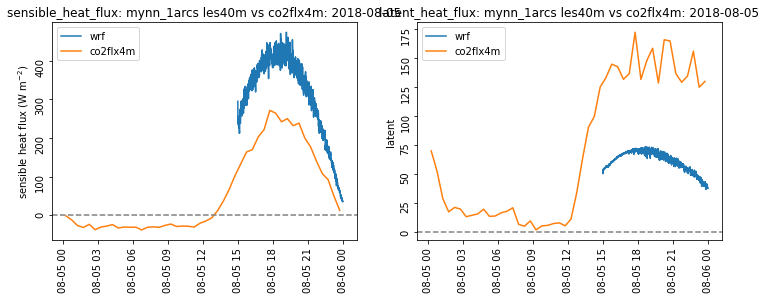

In [36]:
eval_date = '2018-08-05'
for row in ['mynn', 'edmf', 'mynn_1arcs']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

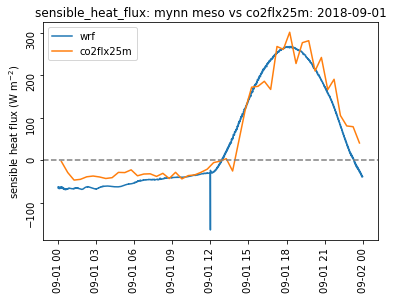

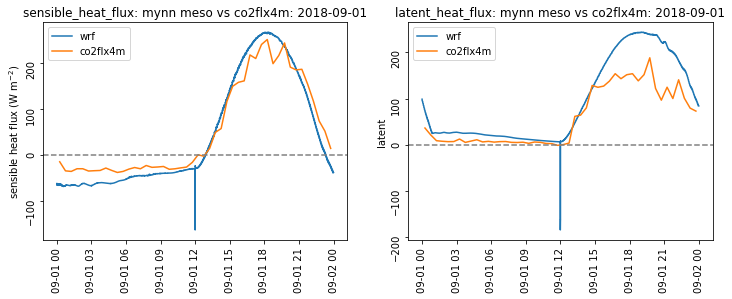

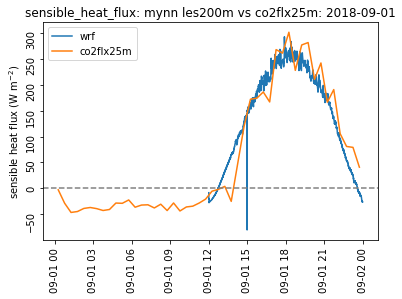

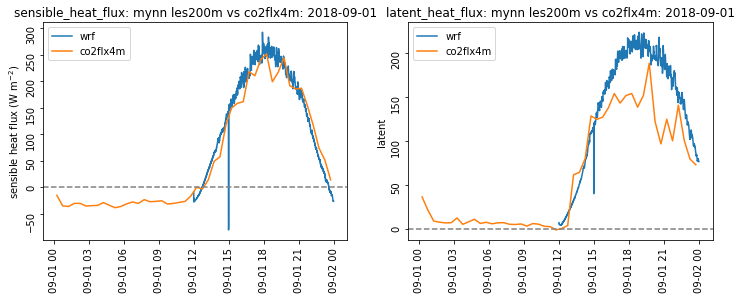

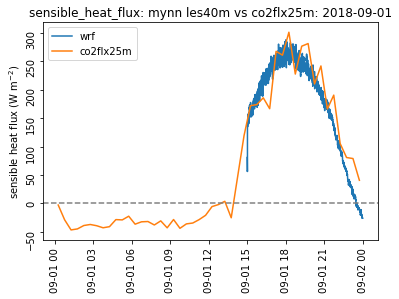

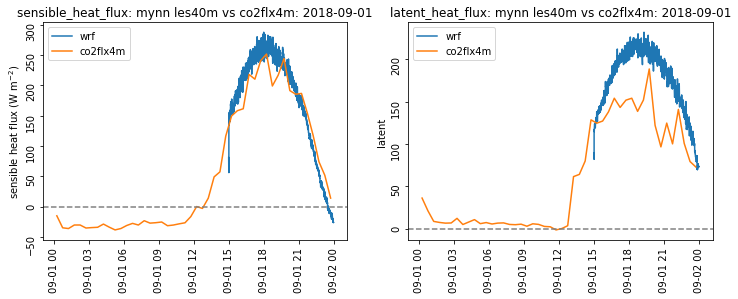

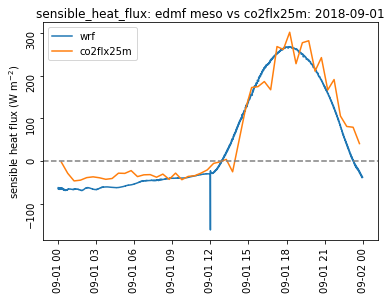

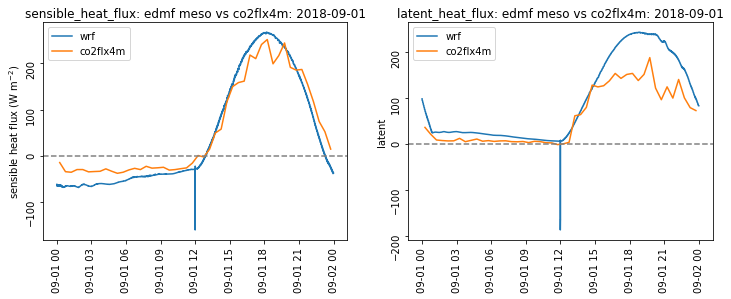

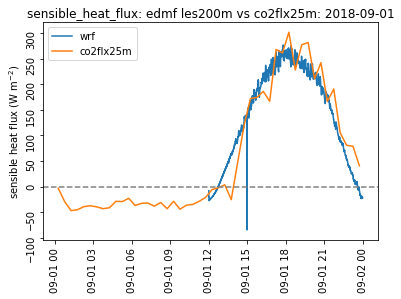

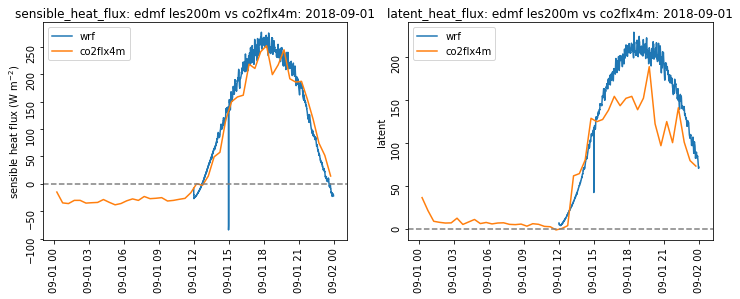

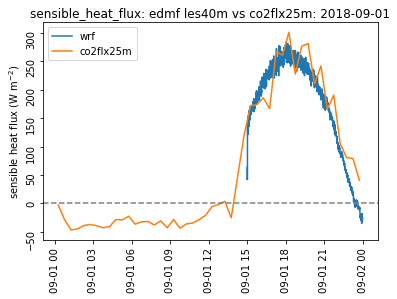

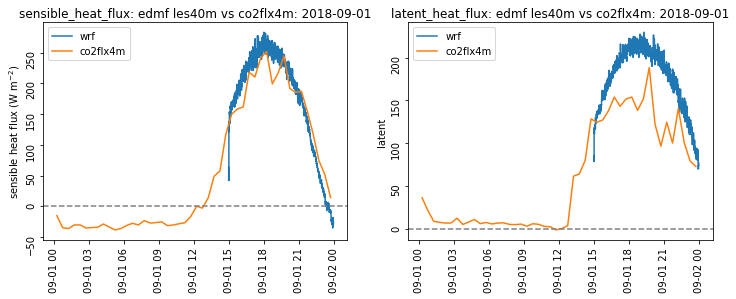

In [6]:
eval_date = '2018-09-01'
for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

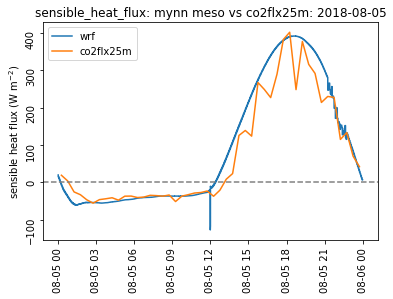

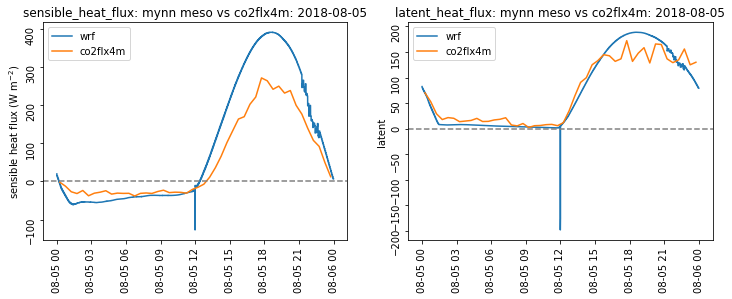

In [18]:
eval_date = '2018-08-05'
mm = plot_flux(eval_date, 'mynn', 'meso')

In [29]:
# checked TS file, hfx IS that odd... starting the inner domain causes the problem??
mm['hfx'].sel(datetime=slice('2018-08-05T11:58', '2018-08-05T12:02'))

<xarray.DataArray 'hfx' (datetime: 30, station: 1)>
array([[ -19.49589],
       [ -19.5514 ],
       [ -19.5992 ],
       [ -19.64952],
       [ -19.70514],
       [ -19.7481 ],
       [ -19.79265],
       [ -19.84283],
       [-127.10773],
       [-116.67835],
       [-117.7855 ],
       [-118.25767],
       [-117.96146],
       [ -10.34582],
       [ -11.78806],
       [ -12.14938],
       [ -12.42465],
       [ -12.70046],
       [ -12.95655],
       [ -13.19956],
       [ -13.43283],
       [ -13.62916],
       [ -13.83105],
       [ -14.02229],
       [ -14.21196],
       [ -14.37398],
       [ -14.54752],
       [ -14.70349],
       [ -14.85901],
       [ -15.00641]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T11:58:00 ... 2018-08-05T12...
  * station   (station) <U4 'z.c1'